In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch

from llava_utils import(
    llava_load_model,
    llava_process_image,
    llava_generate,
    llava_forward_pass,
)
from lens_utils import llava_logit_lens

##### Constants

In [2]:
project_dir = "/vlm-compositionality"

dataset_folder = project_dir+"/data/raw/sugarcrepe",
image_folder = project_dir+"/data/raw/coco"
model_name = "llava-hf/llava-1.5-7b-hf"
image_file = image_folder+"/val2017/000000008690.jpg"
#image_file = image_folder+"/val2014/COCO_val2014_000000562150.jpg"

logit_topk = 50
num_patches = 24

##### Load image

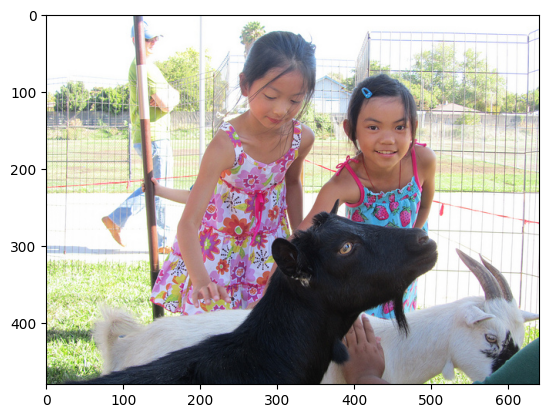

In [3]:
# load image
image = Image.open(image_file).convert("RGB")
plt.imshow(image)

##### Load model

In [4]:
# load model, processor
model, processor = llava_load_model(model_name) #, flash_attention=False, torch_dtype=torch.float32)

You are attempting to use Flash Attention 2.0 without specifying a torch dtype. This might lead to unexpected behaviour


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


##### Process inputs

In [5]:
# process image and prompt(default)
inputs = llava_process_image(image, processor, device=model.device)

In [14]:
torch.count_nonzero((inputs['input_ids'][0] == processor.tokenizer.image_token_id).long())

tensor(576, device='cuda:0')

In [8]:
processor.tokenizer.image_token_id

32000

In [8]:
inputs['pixel_values'].shape

torch.Size([1, 3, 336, 336])

In [16]:
model

LlavaForConditionalGeneration(
  (vision_tower): CLIPVisionModel(
    (vision_model): CLIPVisionTransformer(
      (embeddings): CLIPVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
        (position_embedding): Embedding(577, 1024)
      )
      (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-23): 24 x CLIPEncoderLayer(
            (self_attn): CLIPFlashAttention2(
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn):

In [17]:
336*336 / 196

576.0

##### Get logit lens

In [6]:
# generate
#outputs = llava_generate(inputs, model, output_hidden_states=True)

# forward pass
outputs = llava_forward_pass(inputs, model, output_hidden_states=True)

torch.Size([1, 577, 1024])


RuntimeError: No active exception to reraise

In [ ]:
# vocab_dim, num_layers, num_tokens
softmax_probs = llava_logit_lens(
    inputs,
    model,
    outputs,
    output_type='forward', # or 'generate'
    logit_topk=logit_topk,
)

##### Object

In [33]:
class_ = 'cat'
class_token_indices = processor.tokenizer.encode(class_)[1:]

#### Internal confidence heatmap

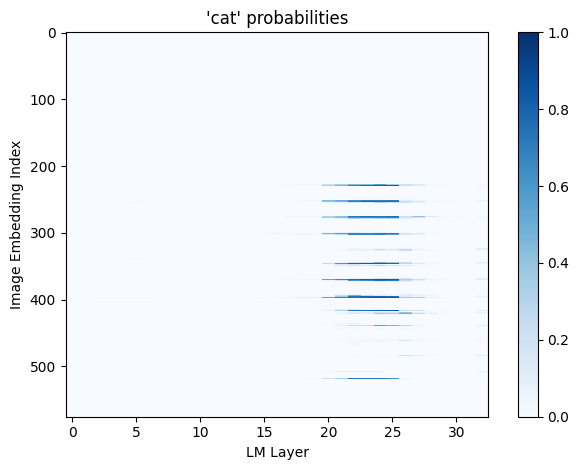

In [34]:
heatmap_data = softmax_probs[class_token_indices].max(axis=0).T
num_image_embeddings = softmax_probs.shape[2]
im = plt.imshow(heatmap_data, aspect=30/num_image_embeddings, cmap='Blues', interpolation='nearest')
plt.title(f"'{class_}' probabilities")
plt.xlabel("LM Layer")
plt.ylabel("Image Embedding Index")
plt.tight_layout()
plt.clim(0, 1)
plt.colorbar()
plt.show()

##### Localization

In [42]:
def viz_localization(softmax_probs, class_token_indices, image, layer=None):

    img_width, img_height = image.size

    if layer is None:
        softmax_probs = softmax_probs[class_token_indices].max(axis=0).max(axis=0)
    else:
        softmax_probs = softmax_probs[class_token_indices].max(axis=0)[layer]
    segmentation = softmax_probs.reshape(num_patches, num_patches).astype(float)

    # TODO: other interpolation methods apart from Image.BILINEAR
    segmentation_resized = (np.array(Image.fromarray(segmentation).resize((img_width, img_height), Image.BILINEAR)))
    plt.imshow(image)
    plt.imshow(segmentation_resized, cmap='jet', interpolation='bilinear', alpha=.5)
    plt.axis('off')
    # TODO: layer in title
    plt.title(f"'{class_},' localization")
    plt.tight_layout()
    plt.show()

##### Max localization

/tmp/ipykernel_7217/2801105813.py:12: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  segmentation_resized = (np.array(Image.fromarray(segmentation).resize((img_width, img_height), Image.BILINEAR)))


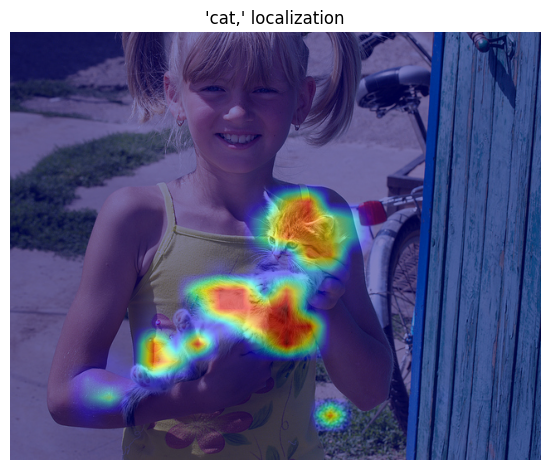

In [43]:
viz_localization(softmax_probs, class_token_indices, image)

##### Localization by layer

In [ ]:
viz_localization(softmax_probs, class_token_indices, image, 25)